In [ ]:
!pip install keras==3.2.1
!pip install underthesea

In [ ]:
import pandas as pd
import numpy as np
import re
from underthesea import word_tokenize

def read_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]
    return lines

def clean(data):
    data = data.split("\n")[0]
    data = data.lower()
    data = re.sub(r'[^a-zaàảãáạăằẳẵắặâầẩẫấậbcdđeèẻẽéẹêềểễếệfghiìỉĩíịjklmnoòỏõóọôồổỗốộơờởỡớợpqrstuùủũúụưừửữứựvwxyỳỷỹýỵz]+',
                  ' ', data, flags=re.IGNORECASE)
    data = re.sub(r'(\D)\1+', r'\1', data)
    return data

def clean_stopwords(text, stopwords):
    text = text.lower()
    words = text.split(" ")
    cleaned_words = [word for word in words if word not in stopwords]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

def word_tokenize_text(text):
    text = word_tokenize(text, format="text")
    return text



df = pd.read_csv('crawl_data_full.csv',  header=1, engine='python')
df.columns = ["Id", "Review", "Key"]
df['Review'] = df['Review'].fillna('')
df['Review'] = df['Review'].apply(clean)
df['Review'] = df['Review'].apply(word_tokenize_text)
df.head(100)

df = df[["Review", "Key"]]
df = df.sample(frac=0.9).reset_index(drop=True)
df.to_csv('crawl_data_xu_ly.csv', index=False,  encoding='utf-8-sig')
print(len(df))
df.head()

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Đọc dữ liệu
df = pd.read_csv('/crawl_data_xu_ly.csv', header=1, engine='python')
df.columns = ["Review", "Key"]

# Tiền xử lý dữ liệu
df['Review'] = df['Review'].fillna('')
tokenized_reviews = df['Review'].str.split()


# Đếm tần suất từ và lọc từ
from collections import Counter
word_counts = Counter(word for review in tokenized_reviews for word in review)
filtered_words = {word: freq for word, freq in word_counts.items() if freq >= 10}
filtered_words["UNK"] = 1

# Chuyển đổi các từ thành chỉ số
word_index = {word: idx for idx, word in enumerate(filtered_words.keys())}
indexed_reviews = [[word_index.get(word, word_index['UNK']) for word in review] for review in tokenized_reviews]

with open('word_index.pkl', 'wb') as f:
    pickle.dump(word_index, f)

# Đảm bảo các chuỗi có độ dài cố định
max_length = 150  # Độ dài tối đa của mỗi chuỗi
X = pad_sequences(indexed_reviews, maxlen=max_length, padding='post')
y = df['Key'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=0)

# Kiểm tra kích thước của các tập dữ liệu
print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_val)}')
print(f'Test size: {len(X_test)}')

# Xây dựng mô hình LSTM
embedding_dim = 300
vocab_size = len(word_index)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

# dừng sớm
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

# Huấn luyện mô hình
model.fit(train_dataset, epochs=15, validation_data=validation_dataset, callbacks=[early_stopping])

# Đánh giá mô hình
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))


# Train size: 21074
# Validation size: 9033
# Test size: 3346
# Epoch 1/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 106s 615ms/step - accuracy: 0.6110 - loss: 0.6698 - val_accuracy: 0.6198 - val_loss: 0.6644
# Epoch 2/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 104s 628ms/step - accuracy: 0.6172 - loss: 0.6663 - val_accuracy: 0.6198 - val_loss: 0.6643
# Epoch 3/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 100s 608ms/step - accuracy: 0.6080 - loss: 0.6736 - val_accuracy: 0.6198 - val_loss: 0.6644
# Epoch 4/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 100s 608ms/step - accuracy: 0.6191 - loss: 0.6652 - val_accuracy: 0.6199 - val_loss: 0.6651
# Epoch 5/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 100s 606ms/step - accuracy: 0.6157 - loss: 0.6666 - val_accuracy: 0.6203 - val_loss: 0.6644
# Epoch 6/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 101s 611ms/step - accuracy: 0.6146 - loss: 0.6666 - val_accuracy: 0.6206 - val_loss: 0.6637
# Epoch 7/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 99s 603ms/step - accuracy: 0.6104 - loss: 0.6687 - val_accuracy: 0.6206 - val_loss: 0.6639
# Epoch 8/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 100s 604ms/step - accuracy: 0.6251 - loss: 0.6597 - val_accuracy: 0.7421 - val_loss: 0.5653
# Epoch 9/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 101s 613ms/step - accuracy: 0.7741 - loss: 0.5093 - val_accuracy: 0.9022 - val_loss: 0.2836
# Epoch 10/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 99s 603ms/step - accuracy: 0.9068 - loss: 0.2616 - val_accuracy: 0.9151 - val_loss: 0.2565
# Epoch 11/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 100s 605ms/step - accuracy: 0.9349 - loss: 0.1987 - val_accuracy: 0.9256 - val_loss: 0.2172
# Epoch 12/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 99s 600ms/step - accuracy: 0.9439 - loss: 0.1717 - val_accuracy: 0.9205 - val_loss: 0.2222
# Epoch 13/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 99s 600ms/step - accuracy: 0.9496 - loss: 0.1577 - val_accuracy: 0.9284 - val_loss: 0.2116
# Epoch 14/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 100s 604ms/step - accuracy: 0.9579 - loss: 0.1378 - val_accuracy: 0.9300 - val_loss: 0.2147
# Epoch 15/15
# 165/165 ━━━━━━━━━━━━━━━━━━━━ 99s 603ms/step - accuracy: 0.9632 - loss: 0.1193 - val_accuracy: 0.9276 - val_loss: 0.2234
# 105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step
# Accuracy: 0.93335325762104

In [ ]:
!mkdir model_train
# Lưu trọng số mô hình
model.save_weights('./model_train/model_weights_full.weights.h5')

# Lưu cấu trúc mô hình
with open('./model_train/model_architecture_full.json', 'w') as f:
    f.write(model.to_json())
!zip -r model_train.zip ./model_train

In [ ]:
!unzip /content/model_train_full_97t_92v_93test.zip
!rm /content/model_train_full_97t_92v_93test.zip

!unzip /content/data_chuyende.zip
!rm /content/data_chuyende.zip

In [ ]:
from tensorflow.keras.models import model_from_json

with open('/content/model_train/model_architecture_full.json', 'r') as f:
    loaded_model = model_from_json(f.read())

loaded_model.load_weights('/content/model_train/model_weights_full.weights.h5')

toàn bộ ốp điện thoại mềm chống sốc in hình helo kity cho iphone promax pro g f
['đúng với mô_tả ko chất_lượng sản_phẩm giao kh đúng size í kh vừa ipx cũng kh vừa ipxsm luôn thời_gian vừa_qua các vụ_việc liên_quan đến lừa_đảo chiếm_đoạt tài_sản trên không_gian mạng đang diễn ra hết_sức phức_tạp có xu_hướng gia_tăng với các phương_thức thủ_đoạn mới tinh_vi khó lường và gây nhiều khó_khăn cho các cơ_quan_chức_năng trong việc phát_hiện điều_tra xử_lý vi_phạm', 'ủa đặt ip se giao ốp ip chi z', 'đặt se nhưng lại giao plus chịu luôn đó', 'giao_lộn ốp']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Không hài lòng: 100.00%


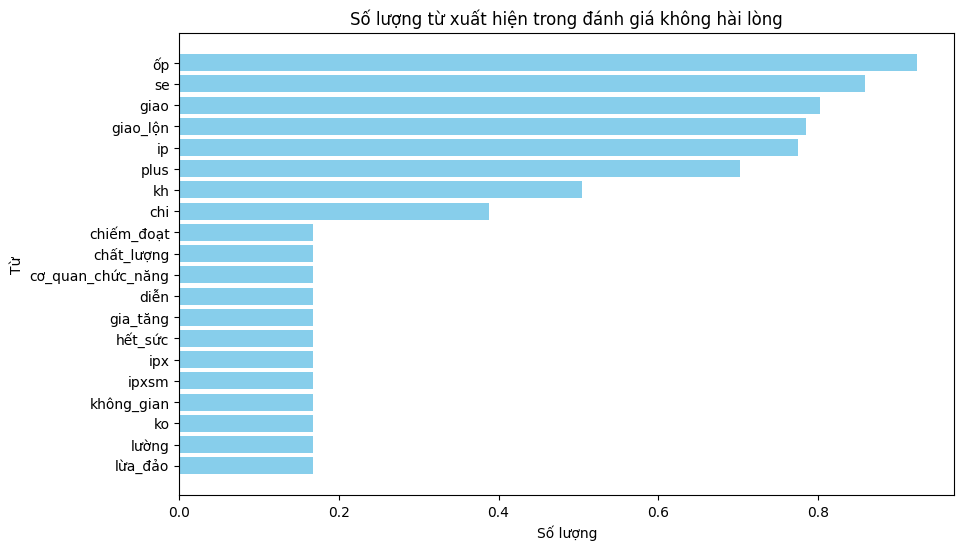

In [ ]:
import pickle
import pandas as pd
import numpy as np
import re
from underthesea import word_tokenize
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

pattern_non_alphabetic = re.compile(r'[^a-zàảãáạăằẳẵắặâầẩẫấậbcdđeèẻẽéẹêềểễếệfghiìỉĩíịjklmnoòỏõóọôồổỗốộơờởỡớợpqrstuùủũúụưừửữứựvwxyỳỷỹýỵz\s]+', re.IGNORECASE)
pattern_repeated_characters = re.compile(r'(\D)\1+')

def clean(data):
    data = str(data)
    data = data.split("\n")[0]
    data = data.lower()
    data = re.sub(pattern_non_alphabetic, ' ', data)
    data = re.sub(pattern_repeated_characters, r'\1', data)
    return data

def word_tokenize_text(text):
    text = word_tokenize(text, format="text")
    return text

def read_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]
    return lines

def load_data(file_path):
    cmts = []
    data = read_file(file_path)
    name = clean(data[0])
    for v in data[1:]:
        cmt = clean(v.split("#")[1])
        cmt = word_tokenize_text(cmt)
        if cmt.strip():
            cmts.append(cmt)
    return name, cmts

def preprocess_reviews(reviews, word_index, max_length):
    tokenized_reviews = [review.split() for review in reviews]
    indexed_reviews = [[word_index.get(word, word_index['UNK']) for word in review] for review in tokenized_reviews]
    padded_reviews = pad_sequences(indexed_reviews, maxlen=max_length, padding='post')
    return padded_reviews

def predict_reviews(reviews, model):
    processed_reviews = preprocess_reviews(reviews, word_index, max_length)
    predictions = (model.predict(processed_reviews) > 0.5).astype("int32")
    return predictions


with open("/content/data_chuyende/word_index.pkl", 'rb') as f:
  word_index = pickle.load(f)

max_length = 150
stop_words_vietnames = read_file("/content/data_chuyende/vietnamese-stopwords-dash.txt")

def print_top_words(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_name = " ".join(top_words)
        topic_names.append(topic_name)
    return topic_names
# Đọc tệp stop words và trả về danh sách các từ
def read_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = file.read().splitlines()
    return stopwords

def review_data(file_path, model):
    name, new_reviews = load_data(file_path)
    print(name)
    print(new_reviews)
    predicted_keys = predict_reviews(new_reviews,model)
    unique_values, counts = np.unique(predicted_keys, return_counts=True)
    ratios = counts / len(predicted_keys) * 100
    result = dict(zip(unique_values, ratios))
    explanation = {
        0: "Không hài lòng",
        1: "Hài lòng"
    }
    for value, ratio in result.items():
        explanation_text = explanation.get(value)
        print(f"{explanation_text}: {ratio:.2f}%")

    unhappy_reviews  = [review for review, key in zip(new_reviews, predicted_keys) if key == 0]

      # Tạo vectorizer với stop words
    vectorizer = TfidfVectorizer(stop_words=stop_words_vietnames)

    # Chuyển đổi các đánh giá không hài lòng thành ma trận TF-IDF
    tfidf_matrix = vectorizer.fit_transform(unhappy_reviews)

    # Lấy danh sách các từ vựng
    vocab = vectorizer.get_feature_names_out()

    # Tính số lượng từ xuất hiện trong tất cả các đánh giá không hài lòng
    word_counts = tfidf_matrix.sum(axis=0).A1

    # Tạo một Counter để đếm số lượng từ
    word_counter = Counter(dict(zip(vocab, word_counts)))

    # Lấy 20 từ xuất hiện nhiều nhất và số lượng tương ứng
    top_words = word_counter.most_common(20)

    # Chia thành danh sách các từ và số lượng tương ứng
    words = [word for word, _ in top_words]
    counts = [count for _, count in top_words]

    # Vẽ biểu đồ cột
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Số lượng')
    plt.ylabel('Từ')
    plt.title('Số lượng từ xuất hiện trong đánh giá không hài lòng')
    plt.gca().invert_yaxis()  # Đảo ngược trục y để từ xuất hiện nhiều nhất được hiển thị trên đầu
    plt.show()

file_path = "data_chuyende/bad_cmt/output_101.txt"
review_data(file_path, loaded_model)

lốc ly nhựa p trơn đáy bằng loại dày ml ml ml ml đựng trà sữa sinh tố nước ép tiện dụng
['đúng với mô_tả_dung chất_lượng sản_phẩm nhua mua lần này lần thứ rồi chất_lượng không chê vào đâu được còn ủng_hộ shop dài dài', 'mua ở shop cũng nhiều lần rồi ly_dày và chắc_chắn nha k mỏng như những chỗ khác nắp đóng khớp và dễ đóng với ly', 'chất_lượng sản_phẩm ok đúng với mô_tả ok sản_phẩm tốt chất_lượng lần sau sẽ mua ủng_hộ tiếp_shop đóng_gói cẩn_thận', 'đúng với mô_tả đúng chất_lượng sản_phẩm nhựa chó là một trong những loài vật_nuôi trong nhà được yêu_thích bởi sự dễ_thương và thông_minh của chúng bài viết tả con chó nuôi trong nhà hay nhất tập làm văn_lớp của luật_minh_khuê sẽ giúp các em học_sinh tìm ra nhiều ý_tưởng mới và hoàn_thiện bài văn_tả con vật của mình một_cách hiệu_quả hơn', 'tại_sao nên chọn concept thanh_xuân cho bộ ảnh kỷ_yếu ưu_đãi khủng_mùa kỷ_yếu một concept với nhiều cái nhất hứa_hẹn sẽ lưu_giữ tuổi của các bạn trọn_vẹn nhất và đây cũng là lý_do vì sao thanh_xuân chưa b

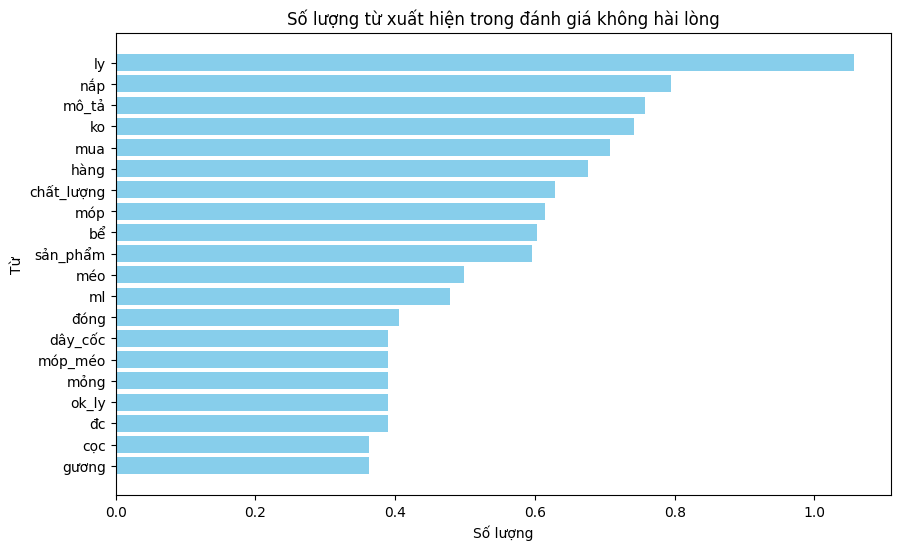

In [ ]:
file_path = "data_chuyende/good_cmt/output_10.txt"
review_data(file_path, loaded_model)